In [1]:
import shap
print(shap.__version__)

/opt/miniconda3/envs/rankingSHAP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.45.1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# print elasticsearch search package version
import elasticsearch
print(elasticsearch.__version__)

(8, 13, 2)


In [6]:
from elasticsearch import Elasticsearch, helpers
import time

# 1. Connect to ES (edit the host/port as needed)
es = Elasticsearch("http://localhost:9200")
index_name = "bm25-demo"

# 2. Delete index if it exists (for repeatable demo)
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

# 3. Create index with BM25 (standard analyzer by default)
mapping = {

    "mappings": {
        "properties": {
            "content": {
                "type": "text",  # Uses BM25 and standard analyzer by default
            }
        }
    }
}
es.indices.create(index=index_name, body=mapping)
print(f"Created index '{index_name}'.")

# 4. Index a few documents
docs = [
    {"content": "The stock market saw gains today in the finance sector."},
    {"content": "Technology advances are happening at a rapid pace."},
    {"content": "Healthy eating and exercise improve overall health."},
    {"content": "Weather forecasts predict rain this week."},
    {"content": "Financial experts recommend saving early for retirement."},
]
actions = [{"_index": index_name, "_source": doc} for doc in docs]
helpers.bulk(es, actions)
print("Indexed documents.")
time.sleep(1)  # Let ES index the docs



import sys
sys.path.append('/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/')
# import rankingSHAP_test_class_cutomized
from rankingSHAP_test_class_cutomized import extract_es_features_optimized, extract_features_from_documents 
# from rankingSHAP_test_class import extract_es_features_optimized
# ----- Usage -----
es = Elasticsearch("http://localhost:9200")
index_name = "bm25-demo"

# Extract features using the optimized method
features = extract_es_features_optimized(es, index_name, field="content")
print(features)
print(len(features))








Created index 'bm25-demo'.
Indexed documents.
['a', 'advances', 'and', 'are', 'at', 'early', 'eating', 'exercise', 'experts', 'finance', 'financial', 'for', 'forecasts', 'gains', 'happening', 'health', 'healthy', 'improve', 'in', 'market', 'overall', 'pace', 'predict', 'rain', 'rapid', 'recommend', 'retirement', 'saving', 'saw', 'sector', 'stock', 'technology', 'the', 'this', 'today', 'weather', 'week']
37


In [7]:
import random

documents = [
    "The stock market saw gains today in the finance sector.",
    "Technology advances are happening at a rapid pace.",
    "Healthy eating and exercise improve overall health.",
    "Weather forecasts predict rain this week.",
    "Financial experts recommend saving early for retirement.",
    "Machine learning models require large datasets for training.",
    "The weather today is sunny and warm.",
    "Exercise and diet are key to maintaining good health."
]

finance_variations = [
    "The stock market saw slight losses today in the tech sector.",
    "Investors showed optimism in the banking industry this morning.",
    "Financial analysts expect interest rates to rise next quarter.",
    "The bond market remained steady amid economic uncertainty."
]

tech_variations = [
    "New breakthroughs in AI are transforming industries rapidly.",
    "Advances in robotics and automation continue to accelerate.",
    "Quantum computing shows promise for solving complex problems.",
    "Tech startups are innovating at an unprecedented pace."
]

health_variations = [
    "Regular exercise and balanced nutrition enhance physical fitness.",
    "Maintaining a healthy diet reduces risk of chronic diseases.",
    "Sleep and hydration play a key role in wellness.",
    "Mental health awareness is becoming increasingly important."
]

weather_variations = [
    "Meteorologists predict heavy snowfall this weekend.",
    "A heatwave is expected to hit the southern region soon.",
    "Storm warnings have been issued for coastal areas.",
    "Temperatures are expected to remain mild throughout the week."
]

ml_variations = [
    "Deep learning models rely heavily on high-quality labeled data.",
    "AI models often require fine-tuning to achieve optimal accuracy.",
    "Model performance depends greatly on data preprocessing.",
    "Training neural networks demands substantial computational resources."
]

all_templates = finance_variations + tech_variations + health_variations + weather_variations + ml_variations + documents

# random combination to make 100 records
synthetic_documents = [random.choice(all_templates) for _ in range(100)]
print(len(synthetic_documents))
# for i, doc in enumerate(synthetic_documents[:10], 1):  # print first 10 for preview
#     print(f"{i}. {doc}")

# # print(f"\nTotal records generated: {len(synthetic_documents)}")


100


In [35]:
from elasticsearch import Elasticsearch, helpers
from typing import List, Dict, Any, Optional
import uuid

class ElasticsearchSparseSearchModel:
    """
    A simple Elasticsearch sparse search model with scikit-learn-like interface.
    Uses BM25 scoring for sparse retrieval.
    """
    
    def __init__(self, es_host: str = "http://localhost:9200", index_name: Optional[str] = None):
        """
        Initialize the Elasticsearch sparse search model.
        
        Args:
            es_host (str): Elasticsearch host URL
            index_name (str, optional): Index name. If None, generates a random one.
        """
        self.es_host = es_host
        self.index_name = index_name or f"sparse_search_{uuid.uuid4().hex[:8]}"
        self.es = None
        self.is_fitted = False
        self.field_name = "content"
        
    def _connect(self):
        """Establish connection to Elasticsearch."""
        if self.es is None:
            try:
                self.es = Elasticsearch(self.es_host)
                if not self.es.ping():
                    raise ConnectionError("Cannot connect to Elasticsearch")
                print(f"Connected to Elasticsearch at {self.es_host}")
            except Exception as e:
                raise ConnectionError(f"Failed to connect to Elasticsearch: {e}")
    
    def fit(self, documents: List[str]) -> 'ElasticsearchSparseSearchModel':
        """
        Fit the model by indexing documents into Elasticsearch.
        
        Args:
            documents (List[str]): List of document texts to index
            
        Returns:
            self: Returns the instance for method chaining
        """
        self._connect()
        
        # Delete existing index if it exists
        if self.es.indices.exists(index=self.index_name):
            self.es.indices.delete(index=self.index_name)
            print(f"Deleted existing index '{self.index_name}'")
        
        # Create index with BM25 settings
        mapping = {
            "mappings": {
                "properties": {
                    self.field_name: {
                        "type": "text",
                        "analyzer": "standard"  # Uses BM25 by default
                    }
                }
            }
        }
        
        try:
            self.es.indices.create(index=self.index_name, **mapping)
            print(f"Created index '{self.index_name}'")
        except Exception as e:
            raise RuntimeError(f"Failed to create index: {e}")
        
        # Index documents
        actions = []
        for i, doc in enumerate(documents):
            actions.append({
                "_index": self.index_name,
                "_id": i,
                "_source": {self.field_name: doc}
            })
        
        try:
            helpers.bulk(self.es, actions)
            self.es.indices.refresh(index=self.index_name)
            print(f"Indexed {len(documents)} documents")
            self.is_fitted = True
        except Exception as e:
            raise RuntimeError(f"Failed to index documents: {e}")
        
        return self
    
    def predict(self, queries: List[str], top_k: int = 5) -> List[List[Dict[str, Any]]]:
        """
        Perform sparse search predictions for given queries.
        
        Args:
            queries (List[str]): List of query strings
            top_k (int): Number of top results to return per query
            
        Returns:
            List[List[Dict]]: For each query, returns list of top_k results.
                            Each result contains: {'doc_id', 'score', 'content'}
        """
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before making predictions. Call .fit() first.")
        
        results = []
        
        for query in queries:
            # Elasticsearch query using BM25
            search_body = {
                "query": {
                    "match": {
                        self.field_name: query
                    }
                },
                "size": top_k,
                "_source": [self.field_name]
            }
            
            try:
                response = self.es.search(index=self.index_name, body=search_body)
                
                query_results = []
                for hit in response['hits']['hits']:
                    result = {
                        'doc_id': hit['_id'],
                        'score': hit['_score'],
                        'content': hit['_source'][self.field_name]
                    }
                    query_results.append(result)
                
                results.append(query_results)
                
            except Exception as e:
                print(f"Error searching for query '{query}': {e}")
                results.append([])  # Return empty results on error
        
        return results
    
    def predict_single(self, query: str, top_k: int = 5) -> List[Dict[str, Any]]:
        """
        Convenience method for single query prediction.
        
        Args:
            query (str): Single query string
            top_k (int): Number of top results to return
            
        Returns:
            List[Dict]: List of top_k results for the query
        """
        results = self.predict([query], top_k)
        return results[0] if results else []
    
    def cleanup(self):
        """Delete the index and clean up resources."""
        if self.es and self.es.indices.exists(index=self.index_name):
            self.es.indices.delete(index=self.index_name)
            print(f"Deleted index '{self.index_name}'")

    def extract_features(self) -> Optional[Any]:
        """
        Extract features using RankingSHAP from the indexed documents.
        
        Returns:
            features: Extracted features or None if extraction fails
        """
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before extracting features. Call .fit() first.")
        
        try:
            from rankingSHAP_test_class_cutomized import extract_es_features_optimized
            features = extract_es_features_optimized(self.es, self.index_name, field=self.field_name)
            return features
        except ImportError as e:
            print(f"Import error: {e}")
            print("Please check the path to your RankingSHAP module")
            return None
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None

# # Sample documents
# documents = [
#     "The stock market saw gains today in the finance sector.",
#     "Technology advances are happening at a rapid pace.",
#     "Healthy eating and exercise improve overall health.",
#     "Weather forecasts predict rain this week.",
#     "Financial experts recommend saving early for retirement.",
#     "Machine learning models require large datasets for training.",
#     "The weather today is sunny and warm.",
#     "Exercise and diet are key to maintaining good health."
# ]
documents = synthetic_documents.copy()

# Create and fit the model
model = ElasticsearchSparseSearchModel()
# Fit the model
print("Fitting model with documents...")
model.fit(documents)
features = model.extract_features()
print(features)
print(len(features))




Fitting model with documents...
Connected to Elasticsearch at http://localhost:9200
Created index 'sparse_search_6a7b01ea'
Indexed 100 documents
['a', 'accelerate', 'accuracy', 'achieve', 'advances', 'ai', 'amid', 'an', 'analysts', 'and', 'are', 'areas', 'at', 'automation', 'awareness', 'balanced', 'banking', 'becoming', 'been', 'bond', 'breakthroughs', 'chronic', 'coastal', 'complex', 'computational', 'computing', 'continue', 'data', 'datasets', 'deep', 'demands', 'depends', 'diet', 'diseases', 'early', 'eating', 'economic', 'enhance', 'exercise', 'expect', 'expected', 'experts', 'finance', 'financial', 'fine', 'fitness', 'for', 'forecasts', 'gains', 'good', 'greatly', 'happening', 'have', 'health', 'healthy', 'heatwave', 'heavily', 'heavy', 'high', 'hit', 'hydration', 'important', 'improve', 'in', 'increasingly', 'industries', 'industry', 'innovating', 'interest', 'investors', 'is', 'issued', 'key', 'labeled', 'large', 'learning', 'losses', 'machine', 'maintaining', 'market', 'mental

In [36]:
model.predict_single("financial market trends", top_k=3)

[{'doc_id': '14',
  'score': 2.938904,
  'content': 'Financial experts recommend saving early for retirement.'},
 {'doc_id': '35',
  'score': 2.938904,
  'content': 'Financial experts recommend saving early for retirement.'},
 {'doc_id': '52',
  'score': 2.938904,
  'content': 'Financial experts recommend saving early for retirement.'}]

In [37]:
from utils.pre_filtering import vocab_prune_by_global_tfidf, normalize_features

In [40]:


features = vocab_prune_by_global_tfidf(documents, keep_top_k=100, ngram_range=(1,1))
print("before stemming/lemmatization:", features)
print("number of features before stemming/lemmatization:", len(features))
features = normalize_features(features)
print("after stemming/lemmatization:", features)
print("number of features after stemming/lemmatization:", len(features))
#     features = {_simple_stem(t) for t in features}



before stemming/lemmatization: {'gains', 'greatly', 'robotics', 'heavy', 'transforming', 'startups', 'snowfall', 'deep', 'saw', 'experts', 'weekend', 'optimism', 'reduces', 'data', 'losses', 'demands', 'healthy', 'solving', 'computational', 'tech', 'saving', 'mental', 'important', 'maintaining', 'early', 'complex', 'finance', 'storm', 'increasingly', 'accuracy', 'depends', 'ai', 'preprocessing', 'meteorologists', 'forecasts', 'morning', 'recommend', 'mild', 'key', 'showed', 'problems', 'require', 'new', 'banking', 'quantum', 'coastal', 'optimal', 'risk', 'wellness', 'accelerate', 'expected', 'datasets', 'innovating', 'rapidly', 'rely', 'week', 'sector', 'sleep', 'large', 'financial', 'investors', 'hydration', 'retirement', 'exercise', 'diet', 'computing', 'role', 'training', 'today', 'shows', 'health', 'play', 'industry', 'pace', 'warnings', 'learning', 'performance', 'chronic', 'breakthroughs', 'awareness', 'high-quality', 'promise', 'substantial', 'advances', 'machine', 'resources', 

In [41]:
from utils.get_explanations import calculate_all_query_explanations
from utils.helper_functions import get_data
import lightgbm
import numpy as np
from scipy.stats import kendalltau
from utils.background_data import BackgroundData
from approaches.ranking_shap import RankingShap
from approaches.ranking_lime import RankingLIME
from approaches.greedy_listwise import GreedyListwise
from approaches.pointwise_lime import AggregatedLime
from approaches.pointwise_shap import AggregatedShap
from approaches.random_explainer import RandomExplainer
from pathlib import Path


explanation_size = 1000
# methods_options = ["tf-idf", "bm25-idf", "intersection"]
# filter_method = methods_options[2]
# print("topk:", topk)
# print("Selected filter method:", filter_method)

# if filter_method == "tf-idf":
#     features = list(topk_vocab_tf_idf)
# if filter_method == "bm25-idf":
#     features = list(topk_vocab_BM25_idf)
# if filter_method == "intersection":
#     features = list(target_vocab)


num_features = len(features)
print(num_features)
background_data_new = np.full((1, num_features), '<unk>', dtype=object)
background_data_new

98


array([['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']],
    

In [42]:
documents

['AI models often require fine-tuning to achieve optimal accuracy.',
 'New breakthroughs in AI are transforming industries rapidly.',
 'Storm warnings have been issued for coastal areas.',
 'Healthy eating and exercise improve overall health.',
 'Quantum computing shows promise for solving complex problems.',
 'Training neural networks demands substantial computational resources.',
 'Maintaining a healthy diet reduces risk of chronic diseases.',
 'Temperatures are expected to remain mild throughout the week.',
 'Healthy eating and exercise improve overall health.',
 'Advances in robotics and automation continue to accelerate.',
 'Weather forecasts predict rain this week.',
 'New breakthroughs in AI are transforming industries rapidly.',
 'Storm warnings have been issued for coastal areas.',
 'Tech startups are innovating at an unprecedented pace.',
 'Financial experts recommend saving early for retirement.',
 'Investors showed optimism in the banking industry this morning.',
 'Maintain

In [43]:
# detokenize(tokenize("AI models often require fine-tuning to achieve optimal accuracy. 123!"))    

In [44]:
documents = list(set(documents))

In [45]:
documents[1]

'A heatwave is expected to hit the southern region soon.'

In [46]:
import sparse_search_bm25 as sparse_search_bm25
import importlib
importlib.reload(sparse_search_bm25)
import json

from sparse_search_bm25 import BM25SearchEngine, demo_bm25_search

# documents = list(set(documents))
print(len(documents))
query = "What is new in stock market?"
preds = demo_bm25_search(query,
                 documents)

28
Indexed 28 documents


In [47]:
len(preds)

28

In [48]:

# import approaches.ranking_shap as ranking_shap_module
import importlib
from approaches import ranking_shap_decoupled_test_v3

importlib.reload(ranking_shap_decoupled_test_v3)
from approaches.ranking_shap_decoupled_test_v3 import RankingShapDecoupled


import rbo
safe_attributions_to = '/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/test_results.csv'


# rank_similarity_coefficient = lambda x, y: rbo.RankingSimilarity(x, y)
rank_similarity_coefficient = lambda x, y: kendalltau(x, y)[0]
# Define all the explainers
ranking_shap_explainer = RankingShapDecoupled(
    permutation_sampler="kernel",
    background_data=background_data_new,
    original_model=demo_bm25_search,
    explanation_size=5, 
    rank_similarity_coefficient=rank_similarity_coefficient,
    nsample_permutations= 300
)



Using kernel weight mode: binom


In [49]:
features = list(features)

In [50]:
masks, metadata = ranking_shap_explainer.generate_masks_only(features, 
                                           query_id= "123")

Generating masks for query: 123
Query features: ['greatly', 'robotics', 'heavy', 'snowfall', 'deep', 'saw', 'weekend', 'optimism', 'startup', 'train', 'data', 'healthy', 'problem', 'computational', 'tech', 'mental', 'important', 'early', 'complex', 'temperature', 'finance', 'storm', 'expert', 'increasingly', 'solve', 'accuracy', 'demand', 'ai', 'preprocessing', 'morning', 'recommend', 'mild', 'key', 'breakthrough', 'maintain', 'bank', 'learn', 'meteorologist', 'require', 'new', 'quantum', 'coastal', 'optimal', 'warning', 'risk', 'wellness', 'accelerate', 'model', 'datasets', 'rapidly', 'rely', 'week', 'sector', 'sleep', 'large', 'financial', 'hydration', 'retirement', 'exercise', 'diet', 'role', 'today', 'reduce', 'health', 'play', 'innovate', 'industry', 'pace', 'investor', 'save', 'performance', 'chronic', 'forecast', 'compute', 'awareness', 'high-quality', 'show', 'promise', 'substantial', 'expect', 'machine', 'loss', 'resource', 'rain', 'remain', 'stock', 'market', 'fine-tune', 'un

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 12.28it/s]

Masks saved to: rankingshap_outputs/masks_123.npz
Metadata saved to: rankingshap_outputs/masks_123_metadata.json
Generated 301 masks


In [51]:
masks

array([['<keep>', '<keep>', '<keep>', ..., '<keep>', '<keep>', '<keep>'],
       ['<unk>', '<unk>', '<unk>', ..., '<unk>', '<unk>', '<unk>'],
       ['<keep>', '<keep>', '<keep>', ..., '<keep>', '<keep>', '<keep>'],
       ...,
       ['<keep>', '<keep>', '<keep>', ..., '<keep>', '<keep>', '<keep>'],
       ['<keep>', '<keep>', '<unk>', ..., '<unk>', '<keep>', '<keep>'],
       ['<unk>', '<unk>', '<keep>', ..., '<keep>', '<unk>', '<unk>']],
      dtype=object)

In [52]:
import os
# timestamp = "20251014_231705"
masks_file = os.path.join("rankingshap_outputs", f"masks_123.npz")

perturbed_results = ranking_shap_explainer.apply_masks_to_documents(masks_file,
                                                documents,
                                                query = query,
                                                output_filename=f"perturbed_data_123.npz")

Loaded 301 masks from rankingshap_outputs/masks_123.npz
Query features: ['greatly', 'robotics', 'heavy', 'snowfall', 'deep', 'saw', 'weekend', 'optimism', 'startup', 'train', 'data', 'healthy', 'problem', 'computational', 'tech', 'mental', 'important', 'early', 'complex', 'temperature', 'finance', 'storm', 'expert', 'increasingly', 'solve', 'accuracy', 'demand', 'ai', 'preprocessing', 'morning', 'recommend', 'mild', 'key', 'breakthrough', 'maintain', 'bank', 'learn', 'meteorologist', 'require', 'new', 'quantum', 'coastal', 'optimal', 'warning', 'risk', 'wellness', 'accelerate', 'model', 'datasets', 'rapidly', 'rely', 'week', 'sector', 'sleep', 'large', 'financial', 'hydration', 'retirement', 'exercise', 'diet', 'role', 'today', 'reduce', 'health', 'play', 'innovate', 'industry', 'pace', 'investor', 'save', 'performance', 'chronic', 'forecast', 'compute', 'awareness', 'high-quality', 'show', 'promise', 'substantial', 'expect', 'machine', 'loss', 'resource', 'rain', 'remain', 'stock', 'm

In [53]:
len(perturbed_results)

301

(array([46., 14.,  9.,  5.,  8.,  6.,  2.,  3.,  4.,  4.,  4.,  4.,  3.,
         2.,  5.,  6.,  7., 10., 11., 48.]),
 array([ 0.  ,  4.85,  9.7 , 14.55, 19.4 , 24.25, 29.1 , 33.95, 38.8 ,
        43.65, 48.5 , 53.35, 58.2 , 63.05, 67.9 , 72.75, 77.6 , 82.45,
        87.3 , 92.15, 97.  ]),
 <BarContainer object of 20 artists>)

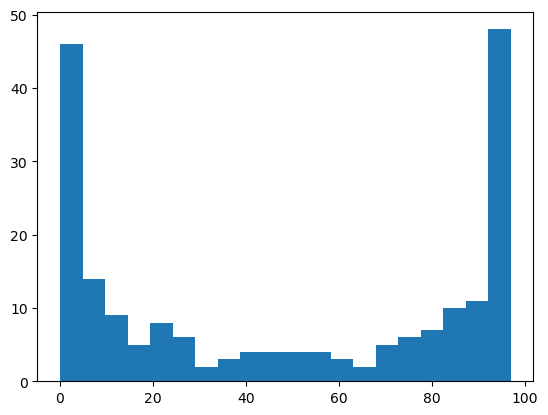

In [54]:
num_masked = []
for mask_index in range(201):
    # mask = perturbed_results[mask_index][0]
    num_masked.append(len(perturbed_results[mask_index][2]['words_replaced']))

import matplotlib.pyplot as plt
plt.hist(num_masked, bins=20)

In [55]:
perturbed_docs = perturbed_results[mask_index][1]
perturbed_docs

['New breakthroughs in AI are transforming industries rapidly.',
 'A heatwave is expected to hit the southern region soon.',
 'Deep learning models rely heavily on high-quality labeled data.',
 'Exercise and diet are key to maintaining good health.',
 'Storm <unk> have been issued for coastal areas.',
 '<unk> showed <unk> in the banking industry this <unk>.',
 'Sleep and hydration play a key role in wellness.',
 'Healthy eating and exercise improve overall health.',
 'Technology advances are happening at a rapid pace.',
 'Training neural networks demands substantial <unk> <unk>.',
 'Meteorologists predict heavy <unk> this weekend.',
 'The stock market saw slight losses today in the <unk> sector.',
 'Temperatures are expected to remain mild throughout the week.',
 'Financial experts recommend saving early for retirement.',
 'Maintaining a healthy diet reduces risk of chronic diseases.',
 'Quantum <unk> shows promise for <unk> complex problems.',
 'Weather forecasts predict rain this wee

In [56]:
perturbed_data_filepath = os.path.join("/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/rankingshap_outputs", 
                                       f"perturbed_data_123.npz")

data = np.load(perturbed_data_filepath, allow_pickle=True)


perturbed_data_filepath


'/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/rankingshap_outputs/perturbed_data_123.npz'

In [57]:
explanation_output = ranking_shap_explainer.calculate_shap_from_perturbed(
    perturbed_data_filepath,
    features,
    query_id ="123",
    documents=documents,
    query = query
)

Calculating SHAP values from: /Users/keqiaoli/Desktop/RankingSHAP/RankingShap/rankingshap_outputs/perturbed_data_123.npz
Loaded 301 precomputed mask-score pairs
Indexed 28 documents
Indexed 28 documents
Empty-coalition baseline (fnull) = 0.645503
Using kernel weight method: binom


In [58]:
explanation_output.safe_to_file('/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/test_results_new.csv')

Writing to  /Users/keqiaoli/Desktop/RankingSHAP/RankingShap/test_results_new.csv
